In [1]:
import dpaleo
import matplotlib.pyplot as plt
import numpy as np

# An implemention of the UCERF3 workflow for NZ-NSHM2022.
### Lower Epistemic Source Scaling


In [2]:
srcscaling_model = "NZNSHM22_lower" # C = 4.1
outfile_tag = "C41"

In [3]:
# this function can go in the dpaleo.py .. anyways
def compute_prob_detectpaleoslip(mag, norm_x =np.linspace(0.00001, 0.5,50), \
                                 srcscaling = "NZNSHM22_mean", detectpaleoslipfactor = 1):
    # get prob of being observble surface-rupture event
    # norm_x in theory can start at 0 but I get a divide by zero warning (not error) ..
    P_sr = dpaleo.prob_detectsurfrup(magnitude=mag, model="NZ_SurfaceRuptureProbability.csv")

    # get average surface slip
    avg_surfslip = dpaleo.mag2avg_surfslip(magnitude=mag, model=srcscaling)

    # get surface slip profile
    slip_x = dpaleo.slip_profile(avg_surfslip, x_by_RL=norm_x, model="sinesqrt")
    prob_paleo_detect = []

    # slip_x is slip profile
    for ii in range(len(slip_x)): 
        sampledslip, slipprob = dpaleo.prob_slip_profpoint(slip_x[ii], xi=norm_x[ii], \
                                                           model = "GEV", normalized = True)
    
        prob_td_x = [] # prob of being detectable at the paleo trench
        for jj in range(len(sampledslip)):
            # model="wrightwood2013"
            temp = dpaleo.prob_detectpaleoslip(sampledslip[jj], \
                                               prob_sampledslip = slipprob[jj], \
                                               model="wrightwood2013", \
                                               slipfactor = detectpaleoslipfactor)
            prob_td_x.append(temp)
    
        prob_td = sum(prob_td_x)
        prob_paleo_detect.append(prob_td*P_sr)
        
    return (norm_x, prob_paleo_detect, avg_surfslip)

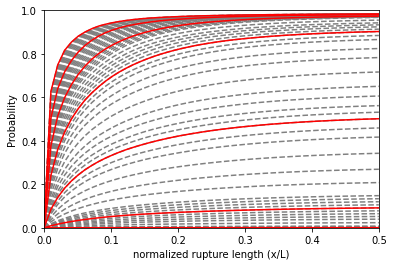

In [4]:
mag = np.arange(5.0, 9.01, 0.05)
for m in mag:
    norm_x, prob_paleo_detect_ww, AD = compute_prob_detectpaleoslip(m, srcscaling = srcscaling_model)
    plt.plot(norm_x, prob_paleo_detect_ww, '--', color = [0.5, 0.5, 0.5])  
    
mag = [6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.01]
#mag = np.arange(5.0, 8.25, 0.05)
for m in mag:
    norm_x, prob_paleo_detect_wws, AD = compute_prob_detectpaleoslip(m, srcscaling = srcscaling_model)
    plt.plot(norm_x, prob_paleo_detect_wws, 'r-')

plt.xlim([0.0, 0.5])
plt.ylim([0.0, 1.0])
plt.xlabel('normalized rupture length (x/L)');
plt.ylabel('Probability');


Figure 6. Probability for detectability of ground-rupture at paleoseismic sites. The lines corresponds to different earthquake magnitudes, and those in red corresponds to magnitudes: Mw 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, and 9.0 in order of the increasing probability.




In [6]:
# let us create a Table similar to Table I2 of Appendix I of UCERF3 report
mag = np.arange(5.5, 9.01, 0.05)

norm_x = np.array([0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.000000001])

print("M AD(M) 0.5 0.45 0.4 0.35 0.3 0.25 0.2 0.15 0.1 0.05 0.0")

out = []
for m in mag:
    tout = []
    norm_x, prob_paleo_detect, AD = compute_prob_detectpaleoslip(m, norm_x = norm_x, \
                                                                srcscaling = srcscaling_model)
    tout.append(round(m,2))
    tout.append(round(AD,3))
    for pi in prob_paleo_detect:
        tout.append(round(pi, 6))
    print(*tout,'    ')
    out.append(tout)

# write out a .txt file
fname = "pdetection_"+outfile_tag+".txt"

# write out a .csv file

import csv 

# open the file in the write mode
f = open(fname, 'w')
# create the csv writer
writer = csv.writer(f, delimiter=' ')
#writer.writerow(['M','AD(M)',0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0])
# The format as in:
# https://github.com/GNS-Science/nzshm-opensha/blob/main/src/main/resources/paleoRates/pdetection2.txt
writer.writerow([0.0, 0.00,0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0])
for row in out:
    # write a row to the csv fil
    writer.writerow(row)

# close the file
f.close()
    

M AD(M) 0.5 0.45 0.4 0.35 0.3 0.25 0.2 0.15 0.1 0.05 0.0
5.5 0.265 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0     
5.55 0.28 1.9e-05 1.8e-05 1.8e-05 1.7e-05 1.6e-05 1.4e-05 1.2e-05 9e-06 7e-06 3e-06 0.0     
5.6 0.297 2.5e-05 2.5e-05 2.4e-05 2.3e-05 2.1e-05 1.9e-05 1.6e-05 1.3e-05 9e-06 5e-06 0.0     
5.65 0.315 3.6e-05 3.5e-05 3.4e-05 3.2e-05 3e-05 2.7e-05 2.4e-05 1.9e-05 1.3e-05 7e-06 0.0     
5.7 0.333 4.8e-05 4.7e-05 4.5e-05 4.3e-05 4e-05 3.7e-05 3.2e-05 2.6e-05 1.8e-05 1e-05 0.0     
5.75 0.353 8.9e-05 8.7e-05 8.4e-05 8e-05 7.5e-05 6.9e-05 6.1e-05 5e-05 3.6e-05 1.9e-05 0.0     
5.8 0.374 0.000133 0.00013 0.000125 0.00012 0.000112 0.000103 9.1e-05 7.5e-05 5.5e-05 2.9e-05 0.0     
5.85 0.396 0.00021 0.000205 0.000198 0.000189 0.000178 0.000165 0.000146 0.000122 8.9e-05 4.8e-05 0.0     
5.9 0.42 0.00029 0.000283 0.000274 0.000262 0.000248 0.000229 0.000205 0.000172 0.000127 7e-05 0.0     
5.95 0.445 0.000504 0.000492 0.000476 0.000456 0.000432 0.0004 0.000359 0.000303 0.000226 0.000